# 1. Import Libraries

In [3]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import os

# NO NEED GPU! CPU will do!

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [10]:
class DQN:
    def __init__(self,
                 InputShape = 4,
                 NActions = 2,
                 Gamma = 1,
                 ReplayMemorySize = 10000,
                 MinReplayMemory = 1000,
                 UpdateTargetEveryThisEpisodes = 1,
                 IntermediateSize = 64,
                 BatchSize = 32):
        
        # Hyperparameters. #
        
        self.InputShape = InputShape
        self.NActions = NActions
        self.Gamma = Gamma
        self.ReplayMemorySize = ReplayMemorySize
        self.MinReplayMemory = MinReplayMemory
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
        self.IntermediateSize = IntermediateSize
        self.BatchSize = BatchSize
        
        # Main model. #
        
        self.Main = self.CreateModel('Main')
        self.Optimiser = Adam()
        
        # Target model. #
        
        self.Target = self.CreateModel('Target')
        self.Target.set_weights(self.Main.get_weights())
        
        # Replay memory. #
        
        self.ReplayMemory = deque(maxlen = ReplayMemorySize)
        
        # Target network update counter. #
        
        self.TargetUpdateCounter = 0
    
    def CreateModel(self, Type):
        inputs = Input(shape = (self.InputShape,), name = 'Input')
        x = Dense(self.IntermediateSize, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.IntermediateSize, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)
        
        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()
        
        return NN
    
    def UpdateReplayMemory(self, Information): # Information = (S, A, R, SNext, Done)
        self.ReplayMemory.append(Information)

    def Train(self, EndOfEpisode):
        
        # Only train if replay memory has enough data. #
        
        if len(self.ReplayMemory) < self.MinReplayMemory:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return
        
        # Get batch of data for training. #
        
        TrainingData = random.sample(self.ReplayMemory, self.BatchSize)
        
        # Get states from training data, then get corresponding Q values. #
        
        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS))
        
        # Get future states from training data, then get corresponding Q values. #
        
        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.Target(ListOfSNext)
        
        # Build actual training data for neural network. #
        
        X = []
        Y = []
        for index, (S, A, R, SNext, Done) in enumerate(TrainingData):
            if not Done:
                MaxQNext = np.max(ListOfQNext[index])
                QNext = R + self.Gamma * MaxQNext
            else:
                QNext = R
            Q = ListOfQ[index]
            Q[A] = QNext
        
            X.append(S)
            Y.append(Q)
        
        # Train model using tf.GradientTape(), defined below.
    
        self.GTfit(X, Y)
                
        # Update target network every episode. #
        
        if EndOfEpisode:
            self.TargetUpdateCounter += 1
        
        # Update target if counter is full. #
        
        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.Target.set_weights(self.Main.get_weights())
            self.TargetUpdateCounter = 0
    
    # This is the tf.GradientTape() which significantly speeds up training of neural networks.
    
    @tf.function
    def GTfit(self, X, Y):
        
        # Train the neural network with this batch of data. #
        
        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            Loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(Loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))

In [11]:
EnvName = 'Pendulum-v0'
IntermediateSize = 64
Epsilon = 0.1
ShowEvery = 10
InputShape = 3
NActions = 40
returns = []

In [12]:
def PendulumActionConverter(A, NActions=NActions):
    ActualTorque = (A / NActions - 0.5) * 4
    return ActualTorque

def PendulumInverseActionConverter(A, NActions=NActions):
    ActualA = round((A + 2) * (NActions - 1) / 4)
    return(ActualA)

def OneEpisode():
    env = gym.make(f'{EnvName}')
    S = env.reset()
    ListOfRewards = []
    Done = False
    while not Done:
        Q = DQN.Main(S.reshape(-1, S.shape[0]))
        if np.random.rand() < Epsilon:
            AStep = env.action_space.sample()
            A = PendulumInverseActionConverter(AStep[0])
        else:
            A = np.argmax(Q)
            A = PendulumActionConverter(A)
            AStep = np.array([A])
            A = PendulumInverseActionConverter(A)
        if not _ % ShowEvery and len(DQN.ReplayMemory) >= DQN.MinReplayMemory:
            env.render()
        SNext, R, Done, Info = env.step(AStep)
        DQN.UpdateReplayMemory((S, A, R, SNext, Done))
        DQN.Train(Done)
        ListOfRewards.append(R)
        if Done:
            print(f'Finished! Return: {np.sum(ListOfRewards)}')
            returns.append(np.sum(ListOfRewards))
            env.close()
            return
        S = SNext

def ReturnPlot():
    plt.figure(figsize=(10, 5))

    plt.plot(returns)
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.legend()

    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig("plots/returns.png")
    plt.show()

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3rdHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,176 (43.66 KB)

 Trainable params: 11,176 (43.66 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3rdHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,176 (43.66 KB)

 Trainable params: 11,176 (43.66 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


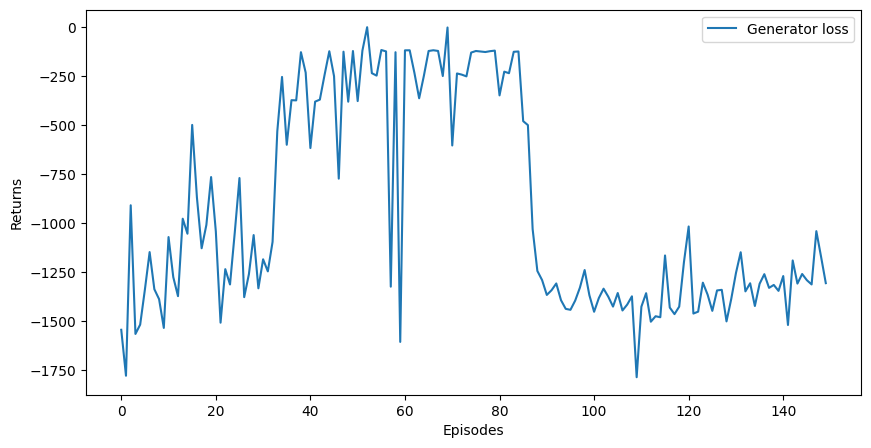

KeyboardInterrupt: 

In [13]:
import time
STARTTIME = time.time()

DQN = DQN(InputShape = InputShape, NActions = NActions)
for _ in range(150):
    print(f'Episode {_}')
    OneEpisode()

print(f'Total time taken: {time.time() - STARTTIME} seconds ...')

ReturnPlot()